In [35]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from nibabel import processing


In [36]:
MR_DIR = '/home/kats/storage/staff/eytankats/data/nako_10k/stitched/'
CT_DIR = '/home/kats/storage/staff/eytankats/data/nako_10k/fake_ct_postprocessed_flipped/'

OUTPUT_MR_DIR = '/home/kats/storage/staff/eytankats/projects/multimodal_ssl/data/mr/'
OUTPUT_CT_DIR = '/home/kats/storage/staff/eytankats/projects/multimodal_ssl/data/ct/'

In [41]:
# get list of generated ct files
ct_paths = sorted(glob(os.path.join(CT_DIR, '*.nii.gz')))

# iterate other ct files and preprocess both ct and corresponding mr image
for ct_path in tqdm(ct_paths[:2]):
    
    # get mr image path 
    img_id = os.path.basename(ct_path)[:6]
    mr_path = os.path.join(MR_DIR, img_id,'wat.nii.gz')  # get mr image path
    
    if not os.path.exists(mr_path):
        continue
    
    # load ct and mr images
    ct_nib = nib.load(ct_path)
    mr_nib = nib.load(mr_path)
    
    # resample mr image to match ct image dimensions
    mr_nib = processing.resample_from_to(mr_nib, to_vox_map=ct_nib)
    
    # get numpy images from nibabel images
    ct_np = ct_nib.get_fdata()
    mr_np = mr_nib.get_fdata()
    
    if ct_np.shape != mr_np.shape:
        continue
    
    # flip mr image to match ct image orientation
    mr_np = np.flip(mr_np, axis=1)
    mr_np = np.flip(mr_np, axis=0)
    
    # crop mr and ct images
    ct_np = ct_np[:, :, 316:500]
    mr_np = mr_np[:, :, 316:500]
    
    # clip ct image using soft tissue window
    ct_clip_min = -175
    ct_clip_max = 250
    ct_np = np.clip(ct_np, -175, 250)
    
    # clip mri image using percentile values
    mr_clip_min = np.percentile(mr_np, 1)
    mr_clip_max = np.percentile(mr_np, 99.99)
    mr_np = np.clip(mr_np, mr_clip_min, mr_clip_max)
    
    # scale images between 0 and 1
    mr_np = (mr_np - mr_clip_min) / (mr_clip_max - mr_clip_min)
    ct_np = (ct_np - ct_clip_min) / (ct_clip_max - ct_clip_min)
    
    # save pre-processed images
    np.save(os.path.join(OUTPUT_MR_DIR, img_id + '.npy'), mr_np)
    np.save(os.path.join(OUTPUT_CT_DIR, img_id + '.npy'), ct_np)
    

100%|██████████| 2/2 [00:12<00:00,  6.03s/it]


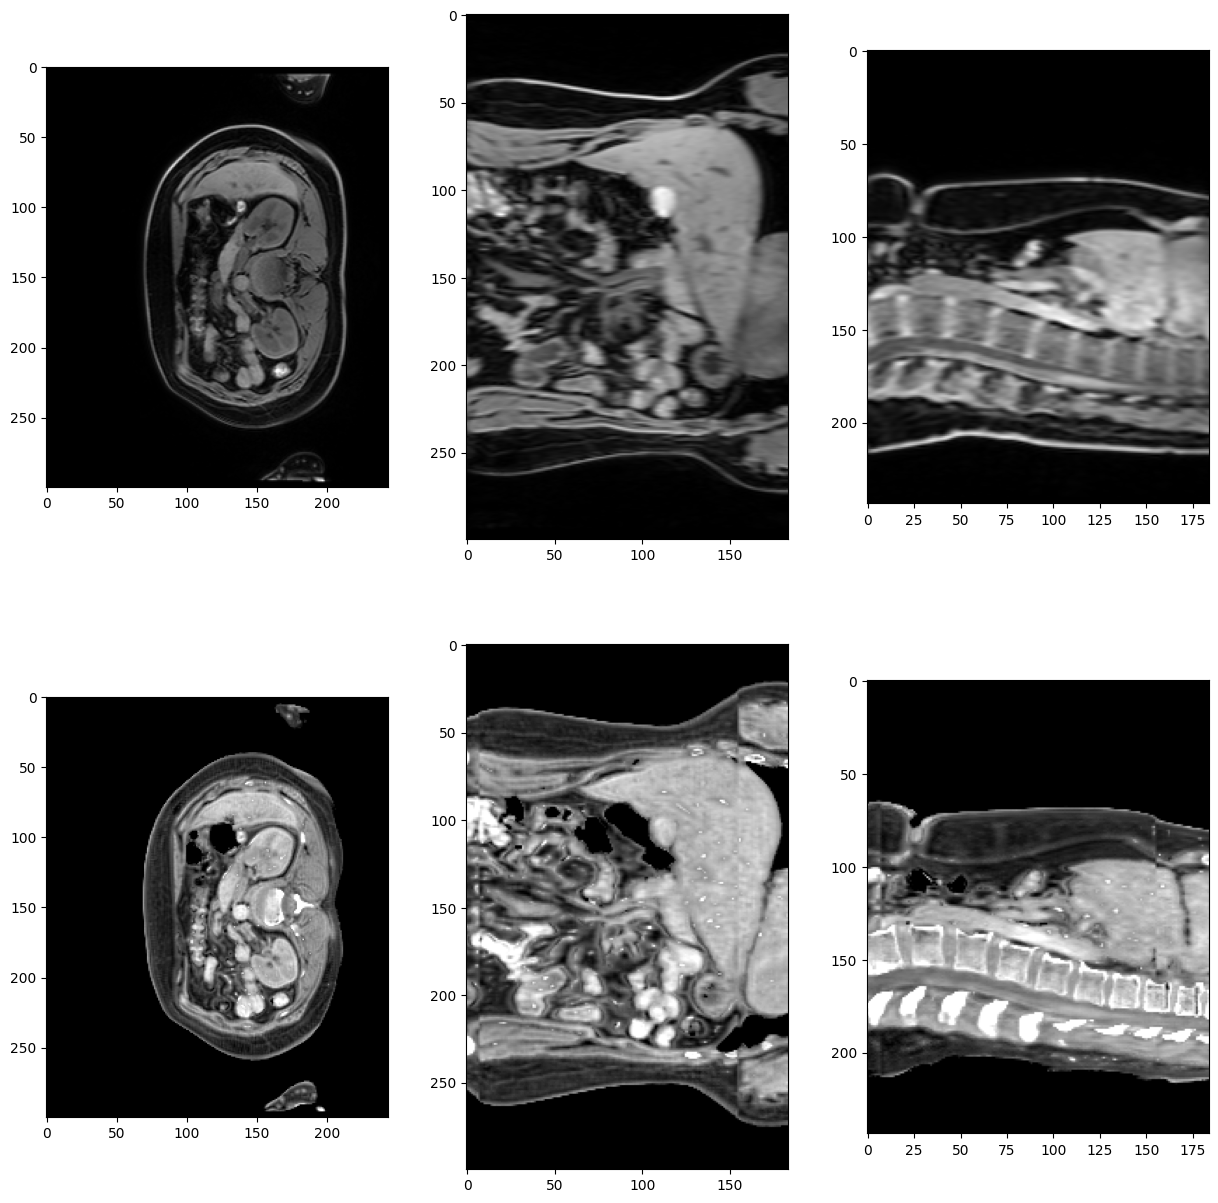

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))
ax[0,0].imshow(mr_np[:,:,mr_np.shape[2] // 2], cmap='gray')
ax[0,1].imshow(mr_np[:,mr_np.shape[1] // 2,:], cmap='gray')
ax[0,2].imshow(mr_np[mr_np.shape[0] // 2,:,:], cmap='gray')

ax[1,0].imshow(ct_np[:,:,ct_np.shape[2] // 2], cmap='gray')
ax[1,1].imshow(ct_np[:,ct_np.shape[1] // 2,:], cmap='gray')
ax[1,2].imshow(ct_np[ct_np.shape[0] // 2,:,:], cmap='gray')